In [1]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 629.2 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, auc, roc_curve, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import category_encoders as ce
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import graphviz
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
import os

# Filter out warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)

# Add Graphviz to the system path
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Data Exploration

In [3]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
# List of Attributes
print(df.columns)

# Rows and Columns in the data set
print(df.shape)

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')
(12684, 26)


| Feature               | Description                                                                 | Data Type                      |
|-----------------------|-----------------------------------------------------------------------------|--------------------------------|
| destination           | Driver’s destination: "No Urgent Place", "Home", "Work"                     | C                              |
| passenger             | The passenger(s) in the car: "Alone", "Friend(s)", "Kid(s)", "Partner"      | C                              |
| weather               | The weather when the driver is driving: "Sunny", "Rainy", "Snowy"           | C                              |
| temperature           | The temperature when the driver is driving (in °F): "55", "80", "30"        | C (continuous data treated as categorical) |
| time                  | The time at which the driver is driving: "2PM", "10AM", "6PM", "7AM", "10PM" | C/numeric categorical (continuous data treated as categorical) |
| coupon                | Type of coupon that will be accepted: "Restaurant(\$<20)", "Coffee House", "Carryout & Take away", "Bar, Restaurant(\$20-\$50)" | C |
| expiration            | The expiration date of the coupon: "1d", "2h"                               | C/numeric categorical (continuous data treated as categorical) |
| gender                | Driver’s gender: "Female", "Male"                                           | C                              |
| age                   | Driver’s age: "21", "46", "26", "31", "41", "50plus", "36", "below21"       | C/numeric categorical (continuous data treated as categorical) |
| maritalStatus         | Driver’s marital status: "Unmarried partner", "Single", "Married partner", "Divorced", "Widowed" | C |
| has_Children          | Whether the driver has child(ren) or not: 0: no, 1: yes                     | C (binary variable)            |
| education             | Driver’s educational background: "Some college - no degree", "Bachelors degree", "Associates degree", "High School Graduate", "Graduate degree (Masters or Doctorate)", "Some High School" | C |
| occupation            | Driver’s occupation: "Unemployed", "Architecture & Engineering", "Student", "Education&Training&Library", "Healthcare Support", "Healthcare Practitioners & Technical", "Sales & Related", "Management", "Arts Design Entertainment Sports & Media", "Computer & Mathematical", "Life Physical Social Science", "Personal Care & Service", "Community & Social Services", "Office & Administrative Support", "Construction & Extraction", "Legal", "Retired", "Installation Maintenance & Repair", "Transportation & Material Moving", "Business & Financial", "Protective Service", "Food Preparation & Serving Related", "Production Occupations", "Building & Grounds Cleaning & Maintenance", "Farming Fishing & Forestry" | C |
| income                | Driver’s income: "\$37500 - \$49999", "\$62500 - \$74999", "\$12500 - \$24999", "\$75000 - \$87499", "\$50000 - \$62499", "\$25000 - \$37499", "\$100000 or More", "\$87500 - \$99999", "Less than \$12500" | C/numeric categorical (continuous data treated as categorical) |
| Car                   | Car model driven by the driver: "Scooter and motorcycle", "crossover", "Mazda5" | C                              |
| Bar                   | The frequency of restaurant visits per month: "never", "less1", "13", "gt8", "nan48" | C                              |
| CoffeeHouse           | Frequency of cafe visits per month: "never", "less1", "48", "13", "gt8", "nan" | C/numeric categorical (continuous data treated as categorical) |
| CarryAway             | Frequency of takeaway food consumption per month: "n48", "13", "gt8", "less1", "never" | C/numeric categorical (continuous data treated as categorical) |
| RestaurantLessThan20  | Frequency of restaurant visits per month, where the average expense per person is less than \$20: "48", "13", "less1", "gt8", "never" | C/numeric categorical (continuous data treated as categorical) |
| Restaurant20To50      | Frequency of restaurant visits per month, where the average expense per person is between \$20-\$50: "13", "less1", "never", "gt8", "48", "nan" | C/numeric categorical (continuous data treated as categorical) |
| toCoupon_GEQ5min      | Open to travelling beyond a 5-minute distance to use the coupon: 0: no, 1: yes | C (binary variable)            |
| toCoupon_GEQ15min     | Open to travelling beyond a 15-minute distance to use the coupon: 0: no, 1: yes | C (binary variable)            |
| toCoupon_GEQ25min     | Open to travelling beyond a 25-minute distance to use the coupon: 0: no, 1: yes | C (binary variable)            |
| direction_same        | Whether the restaurant or cafe mentioned in the coupon is in the same direction as drivers’ current destination: 0: no, 1: yes | C (binary variable)            |
| direction_opp         | Whether the restaurant or cafe mentioned in the coupon is in the opposite direction as drivers’ current destination: 0: no, 1: yes | C (binary variable)            |
| Y                     | Whether the driver will accept the coupon or not: 0: no, 1: yes              | C (binary variable)            |


In [5]:
# Data types
print(df.dtypes)

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object


# Data Cleaning

### Missing values

In [6]:
# Find Missing Values
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [7]:
# Missing values in %
missing_percentage = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'missing_count': df.isnull().sum(), 'missing_percentage': missing_percentage})
missing_value_df[missing_value_df['missing_count'] != 0]

,missing_count,missing_percentage
car,12576,99.148534
Bar,107,0.843582
CoffeeHouse,217,1.710817
CarryAway,151,1.190476
RestaurantLessThan20,130,1.024913
Restaurant20To50,189,1.490066


In [8]:
# Remove "car" for having more than 5% missing values
df = df.drop('car', axis=1)

# Shape of data after dropping mv
print(df.shape)

(12684, 25)


### Duplicates


In [9]:
# Check for duplicates based on all columns
duplicates = df.duplicated()

# Filter the DataFrame to show duplicated rows
duplicate_rows = df[duplicates]

# Print the number of duplicate rows
num_duplicates = len(duplicate_rows)
print(f"Number of duplicate rows: {num_duplicates}")

# Print the duplicated rows themselves
print("\nDuplicate Rows:")
print(duplicate_rows)

Number of duplicate rows: 74

Duplicate Rows:
     destination passanger weather  temperature  time                 coupon  \
4192        Work     Alone   Sunny           80   7AM  Carry out & Take away   
4236        Work     Alone   Sunny           80   7AM  Carry out & Take away   
4280        Work     Alone   Sunny           80   7AM  Carry out & Take away   
4324        Work     Alone   Sunny           80   7AM  Carry out & Take away   
4409        Work     Alone   Sunny           80   7AM  Carry out & Take away   
...          ...       ...     ...          ...   ...                    ...   
8511        Home     Alone   Sunny           80   6PM                    Bar   
8512        Home   Partner   Sunny           30  10PM  Carry out & Take away   
8513        Work     Alone   Rainy           55   7AM        Restaurant(<20)   
8515        Work     Alone   Snowy           30   7AM      Restaurant(20-50)   
8516        Work     Alone   Sunny           80   7AM        Restaurant(<2

In [10]:
# Drop duplicates
df = df.drop_duplicates()

# Shape of data after dropping duplicates (12684 to 12610)
df.shape

(12610, 25)

# Exploratory Data Analysis (EDA)

In [12]:
# Summary Statistics
for column in df.columns:
    category_counts = df[column].value_counts()
    category_proportions = category_counts / len(df) * 100
    frequency_table_df = pd.DataFrame({'Frequency': category_counts, 'Percentage': category_proportions})
    frequency_table_df['Percentage'] = frequency_table_df['Percentage'].map('{:.2f}%'.format)

    print(f"Frequency Table for {column}:")
    print(frequency_table_df)
    print()


# Loop through each categorical attribute and create an interactive histogram
for attribute in df.columns:
    fig = px.histogram(df, x=attribute, title=f'Distribution of {attribute}', color_discrete_sequence=px.colors.sequential.Viridis)
    fig.update_layout(
        xaxis_title=attribute,
        yaxis_title='Count',
        width=700,
        height=400,
    )
    fig.show()

Output hidden; open in https://colab.research.google.com to view.

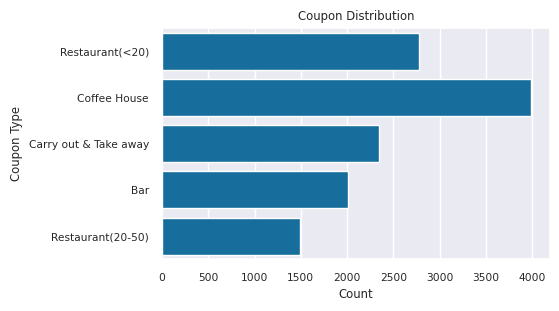

In [13]:
# Coupon distribution
sns.set(font_scale=0.7)
plt.figure(figsize=(5,3))
sns.countplot(y="coupon", data=df, color=sns.color_palette("colorblind")[0])
plt.title('Coupon Distribution')
plt.xlabel('Count')
plt.ylabel('Coupon Type')
plt.show()

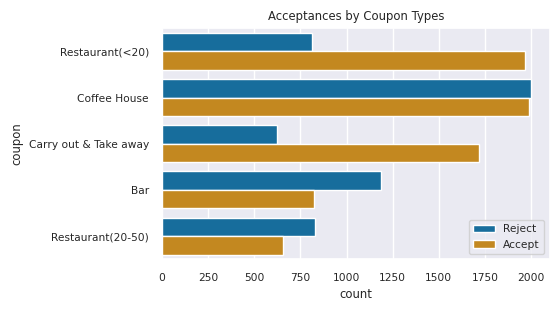

In [14]:
# Acceptance by coupon types
plt.figure(figsize=(5,3))
sns.countplot(y="coupon", hue="Y", data=df, palette="colorblind")

plt.title('Acceptances by Coupon Types')
legend_labels = ['Reject', 'Accept']
plt.legend(legend_labels)

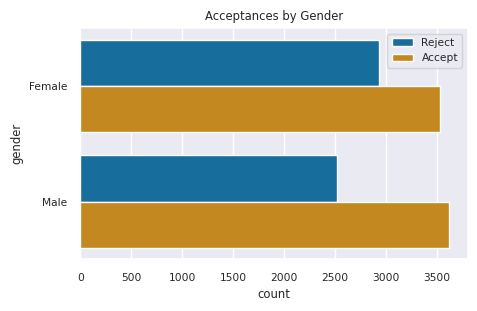

In [15]:
# Acceptance by gender
plt.figure(figsize=(5,3))
sns.countplot(y="gender", hue="Y",data=df, palette="colorblind")

plt.title('Acceptances by Gender')
legend_labels = ['Reject', 'Accept']
plt.legend(legend_labels)

Text(0.5, 1.0, 'Distribution of occupation')

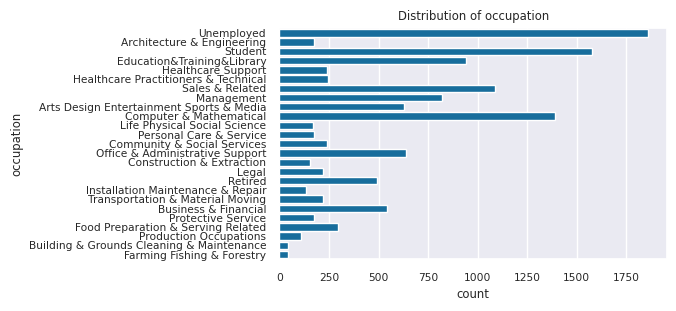

In [16]:
# Distribution of occupation
plt.figure(figsize=(5,3))
sns.countplot(y="occupation",data=df, color=sns.color_palette("colorblind")[0])
plt.title('Distribution of occupation')

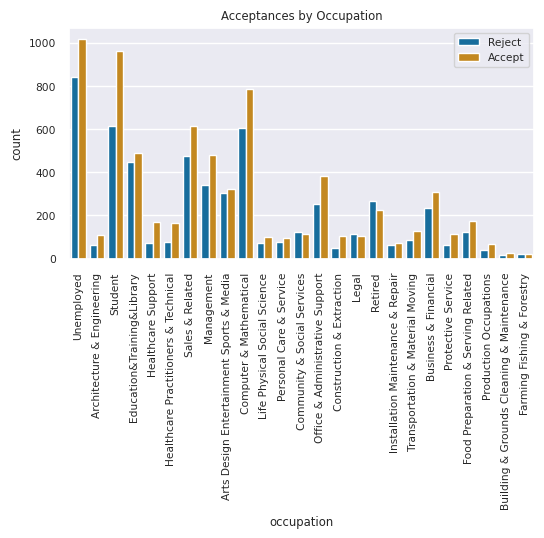

In [17]:
# Occupation
plt.figure(figsize=(6, 3))
sns.countplot(x="occupation", hue="Y", data=df, palette="colorblind")
plt.title('Acceptances by Occupation')
legend_labels = ['Reject', 'Accept']
plt.legend(legend_labels)
plt.xticks(rotation=90)
plt.show()

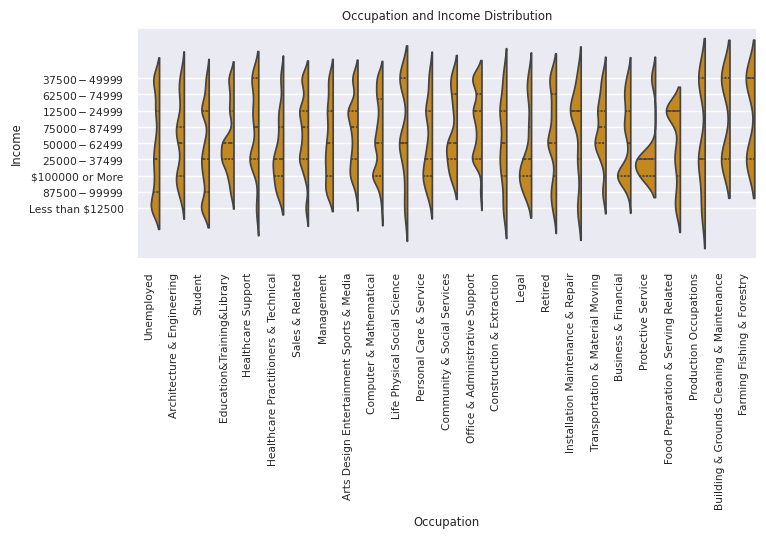

In [18]:
# Occupation and income
plt.figure(figsize=(8, 3))
sns.violinplot(x="occupation", y="income", data=df, color=sns.color_palette("colorblind")[1], inner="quartile", split=True)
plt.title('Occupation and Income Distribution')
plt.xlabel('Occupation')
plt.ylabel('Income')
plt.xticks(rotation=90)
plt.show()

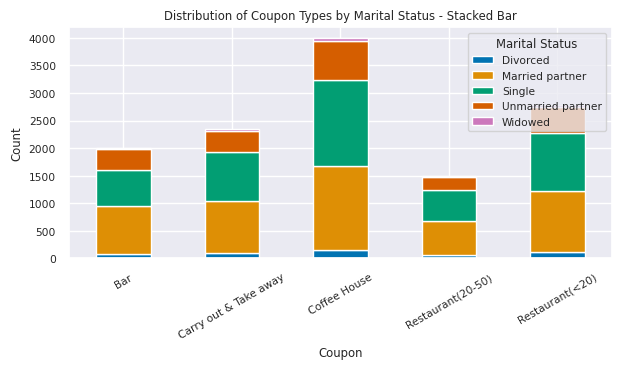

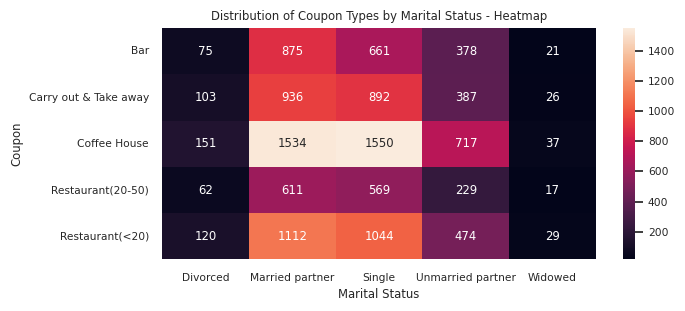

In [19]:
# Create a pivot table
pivot_table = df.pivot_table(index='coupon', columns='maritalStatus', aggfunc='size', fill_value=0)

# Stacked bar plot - Distribution of Coupon Types by Marital Status
pivot_table.plot(kind='bar', stacked=True, color=sns.color_palette("colorblind"), figsize=(7, 3))

plt.title('Distribution of Coupon Types by Marital Status - Stacked Bar')
plt.xlabel('Coupon')
plt.xticks(rotation=30)
plt.ylabel('Count')
plt.legend(title='Marital Status')
plt.show()

# Create a pivot table
heatmap_data = df.pivot_table(index='coupon', columns='maritalStatus', aggfunc='size', fill_value=0)

# Plot a heatmap
plt.figure(figsize=(7, 3))
sns.heatmap(heatmap_data, annot=True, fmt="d", color=sns.color_palette("colorblind"), cbar=True)

plt.title('Distribution of Coupon Types by Marital Status - Heatmap')
plt.xlabel('Marital Status')
plt.ylabel('Coupon')
plt.show()

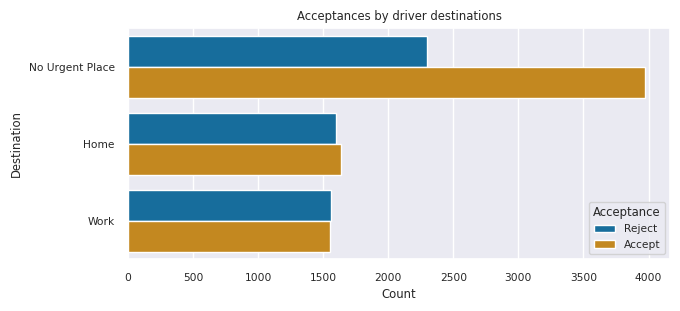

In [20]:
# Destination vs acceptance
plt.figure(figsize=(7, 3))
sns.countplot(y="destination", hue="Y", data=df, palette="colorblind")

plt.title('Acceptances by driver destinations')
plt.xlabel('Count')
plt.ylabel('Destination')
legend_labels = ['Reject', 'Accept']
plt.legend(legend_labels, title='Acceptance')
plt.show()

<Figure size 700x300 with 0 Axes>

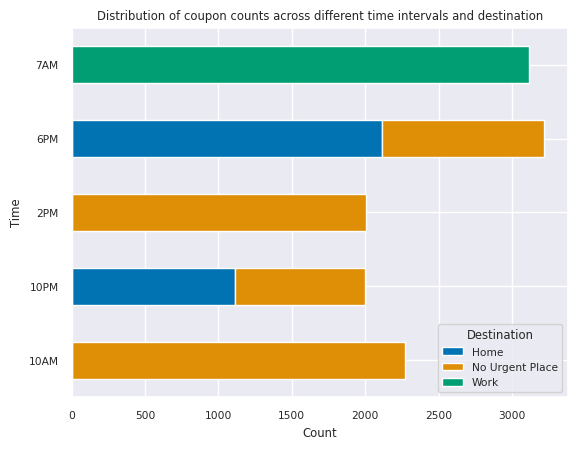

In [21]:
# Distribution of coupon counts across different time intervals and destination
pivot_table = df.pivot_table(index='time', columns='destination', values='coupon', aggfunc='size', fill_value=0)

plt.figure(figsize=(7, 3))  # Adjust figure size as needed
pivot_table.plot(kind='barh', stacked=True, color=sns.color_palette("colorblind"))

plt.title('Distribution of coupon counts across different time intervals and destination')
plt.xlabel('Count')
plt.ylabel('Time')
plt.legend(title='Destination')
plt.show()

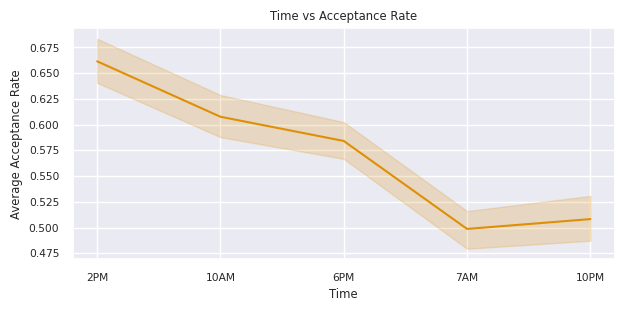

In [22]:
time = df['time']  # Assuming 'time' is your time data
acceptance_rate = df['Y']  # Replace with actual acceptance rate data

plt.figure(figsize=(7, 3))
sns.lineplot(x=time, y=acceptance_rate, color=sns.color_palette("colorblind")[1])
plt.title('Time vs Acceptance Rate')
plt.xlabel('Time')
plt.ylabel('Average Acceptance Rate')
plt.show()

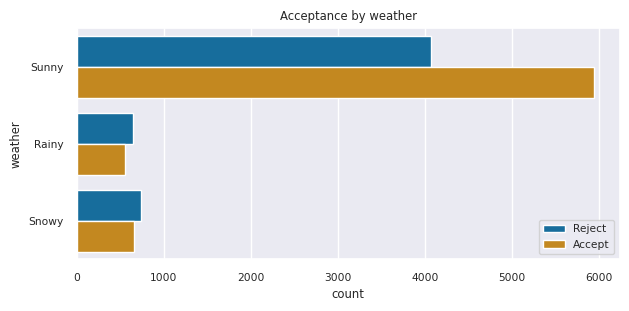

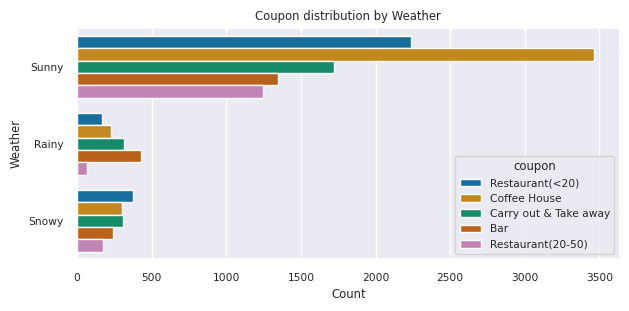

In [23]:
# Weather ve acceptance
plt.figure(figsize=(7, 3))
sns.countplot(y="weather", hue="Y",data=df, palette="colorblind")
plt.title('Acceptance by weather')
legend_labels = ['Reject', 'Accept']
plt.legend(legend_labels)

# Weather vs coupon distribution
plt.figure(figsize=(7, 3))
ax = sns.countplot(y="weather", hue="coupon", data=df, palette="colorblind")
plt.title('Coupon distribution by Weather')
plt.xlabel('Count')
plt.ylabel('Weather')
plt.show()


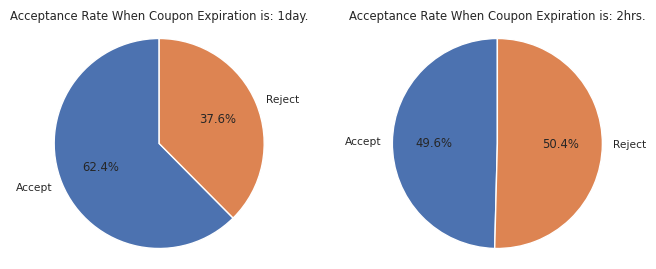

In [24]:
# Coupon expiration vs acceptance

# Filter data for expiration times "1d" and "2h"
coupon_data_1d = df[df['expiration'] == "1d"]
coupon_data_2h = df[df['expiration'] == "2h"]

# Calculate acceptance rates
acceptance_rate_1d = coupon_data_1d['Y'].mean()  # Mean will give acceptance rate because Y is likely a binary indicator
acceptance_rate_2h = coupon_data_2h['Y'].mean()

# Two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Plot first pie chart for exp "1d"
ax1.pie([acceptance_rate_1d, 1 - acceptance_rate_1d], labels=['Accept', 'Reject'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Acceptance Rate When Coupon Expiration is: 1day.')

# Plot second pie chart for exp "2h"
ax2.pie([acceptance_rate_2h, 1 - acceptance_rate_2h], labels=['Accept', 'Reject'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Acceptance Rate When Coupon Expiration is: 2hrs.')

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
ax2.axis('equal')

plt.show()

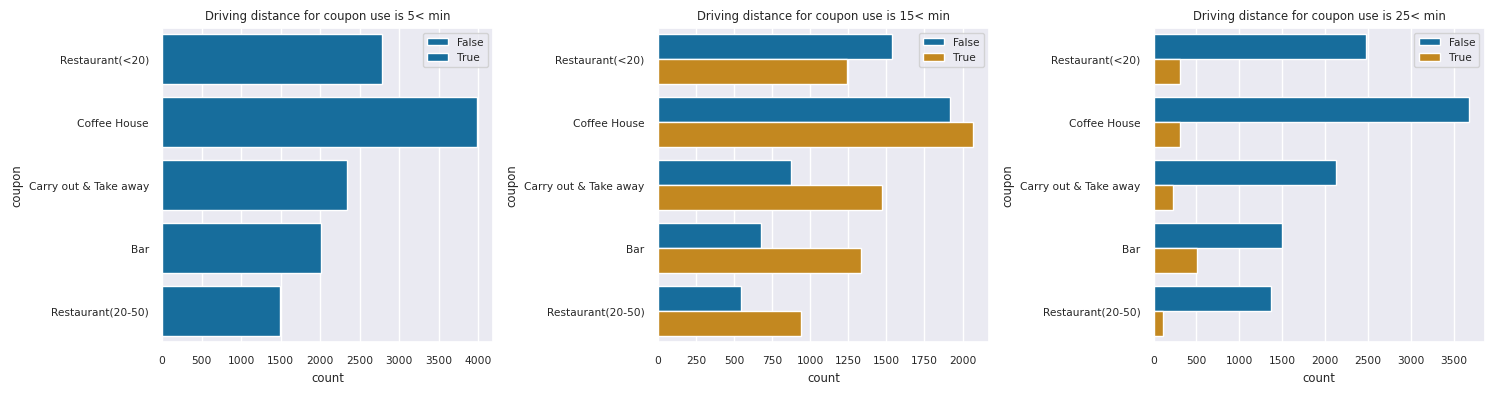

In [25]:
# The driving distances to the restaurant, cafe, or bar for coupon use
distance_columns = ["toCoupon_GEQ5min", "toCoupon_GEQ15min", "toCoupon_GEQ25min"]
titles = ["Driving distance for coupon use is 5< min",
          "Driving distance for coupon use is 15< min",
          "Driving distance for coupon use is 25< min"]

# Create subplots in a loop
fig, axes = plt.subplots(nrows=1, ncols=len(distance_columns), figsize=(15, 4))

for i, col in enumerate(distance_columns):
    sns.countplot(y="coupon", hue=col, data=df, ax=axes[i], palette="colorblind")
    axes[i].set_title(titles[i])
    axes[i].legend(['False', 'True'])

plt.tight_layout()
plt.show()

In [26]:
# Split
X = df.drop(['Y'], axis=1) # Input/feature vector
y = df['Y'] # Target

# Data Transformation

In [27]:
# Ordinal Encoder
encoder = ce.OrdinalEncoder(cols=df.columns[:-1])

# Encode the attributes
coupon_data_encoded = encoder.fit_transform(df)

# Split the data into predictors and target('Y')
predictors = coupon_data_encoded.drop(['Y'], axis=1)
target = df['Y']

#S plit the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.3, random_state = 42)

#C heck the instances of X_train and X_test
X_train.shape, X_test.shape

((8827, 24), (3783, 24))

In [28]:
# Show that encoding has been performed
X_train.head()
X_test.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
8199,1,2,3,3,5,3,1,2,4,2,...,3,3,2,2,2,1,2,1,1,1
11463,1,3,1,1,3,1,2,1,5,3,...,1,5,3,4,5,1,2,1,1,1
1945,1,2,1,2,1,2,1,2,5,3,...,2,3,1,2,2,1,2,1,1,1
8040,1,2,1,2,3,2,1,2,4,2,...,3,2,1,3,3,1,1,1,1,1
9433,1,1,1,2,5,1,1,2,7,2,...,1,2,3,4,3,1,1,1,1,1


# Model 1: Decision Tree Classification

In [29]:
# Base Tree
dt_base = tree.DecisionTreeClassifier(random_state=21)

# Train Decision Tree Classifier
dt_base_fit=dt_base.fit(X_train,y_train)
predict_base=dt_base_fit.predict(X_test)
print('Number of tree nodes of the base model: ', dt_base_fit.tree_.node_count)

# Accuracy of the base model
acc_score=accuracy_score(y_test, predict_base)
print("Accuracy score of the base model:", '%.2f'%acc_score)

Number of tree nodes of the base model:  4583
Accuracy score of the base model: 0.69


## Tuning: Adjust max_depth

max_depth=1, Average 10-Fold CV Score:0.610071371927042, Node count:3
max_depth=2, Average 10-Fold CV Score:0.6162569389373515, Node count:7
max_depth=3, Average 10-Fold CV Score:0.6454401268834259, Node count:15
max_depth=4, Average 10-Fold CV Score:0.6394924662965901, Node count:31
max_depth=5, Average 10-Fold CV Score:0.6762886597938145, Node count:63
max_depth=6, Average 10-Fold CV Score:0.68152260111023, Node count:127
max_depth=7, Average 10-Fold CV Score:0.6800158604282316, Node count:253
max_depth=8, Average 10-Fold CV Score:0.6746233148295004, Node count:457
max_depth=9, Average 10-Fold CV Score:0.659714512291832, Node count:761
max_depth=10, Average 10-Fold CV Score:0.6486915146708963, Node count:1171
max_depth=11, Average 10-Fold CV Score:0.6438540840602697, Node count:1663
max_depth=12, Average 10-Fold CV Score:0.6269627279936557, Node count:2213
max_depth=13, Average 10-Fold CV Score:0.621808088818398, Node count:2771
max_depth=14, Average 10-Fold CV Score:0.60975416336241

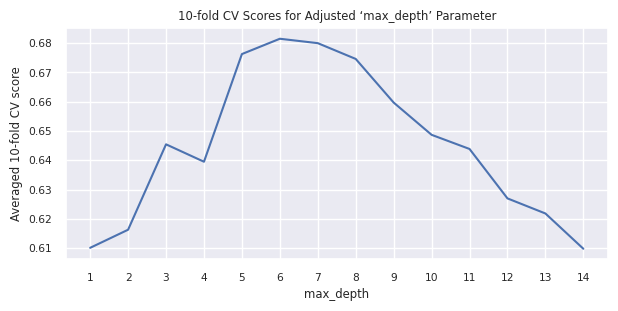

In [30]:
# Adjust 'max_depth' parameter to reduce tree size and improve accuracy of the model
maxdepth_cv=[]
node_counts=[]
for k in range(1,15,1):
    dt=DecisionTreeClassifier(max_depth=k,random_state=21)
    dt.fit(X_train,y_train)
    predict=dt.predict(X_test)
    cv= cross_val_score(dt,predictors,target,cv=10)
    nodecount = dt.tree_.node_count
    print("max_depth={},".format(k), "Average 10-Fold CV Score:{},".format(np.mean(cv)),
          "Node count:{}".format(nodecount))
    maxdepth_cv.append(np.mean(cv))
    node_counts.append(nodecount)


# Plot averaged CV scores for all max_depth tunings
fig,axes=plt.subplots(1,1,figsize=(7,3))
axes.set_xticks(range(1,15,1))
k=range(1,15,1)
plt.title("10-fold CV Scores for Adjusted ‘max_depth’ Parameter")
plt.plot(k,maxdepth_cv)
plt.xlabel("max_depth")
plt.ylabel("Averaged 10-fold CV score")
plt.grid(True)
plt.show()

Number of tree nodes after optimising max depth:  127


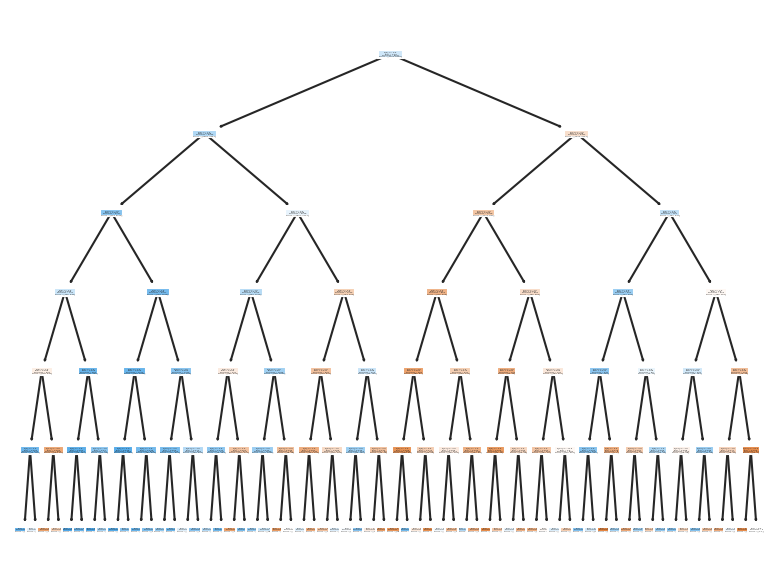

Accuracy score of the model with tuned max_depth: 0.70


In [31]:
# Tune tree using optimal max_depth(6)
dt_dep=DecisionTreeClassifier(max_depth=6,random_state=21)
dt_dep_fit=dt_dep.fit(X_train,y_train)
predict_dep=dt_dep.predict(X_test)
print('Number of tree nodes after optimising max depth: ', dt_dep_fit.tree_.node_count)

# Plot tree
plt.figure(dpi=150)
tree.plot_tree(dt_dep,filled=True)
plt.show()

# Accuracy after tuning max_depth
acc_score=accuracy_score(y_test, predict_dep)
print("Accuracy score of the model with tuned max_depth:", '%.2f'%acc_score)

### Tuning: Adjust max_leaf_nodes

max_leaf_nodes=2, Average 10-Fold CV Score:0.610071371927042,
max_leaf_nodes=3, Average 10-Fold CV Score:0.610071371927042,
max_leaf_nodes=4, Average 10-Fold CV Score:0.6264869151467091,
max_leaf_nodes=5, Average 10-Fold CV Score:0.6354480570975417,
max_leaf_nodes=6, Average 10-Fold CV Score:0.6383822363203807,
max_leaf_nodes=7, Average 10-Fold CV Score:0.6360031720856464,
max_leaf_nodes=8, Average 10-Fold CV Score:0.6444885011895322,
max_leaf_nodes=9, Average 10-Fold CV Score:0.6524980174464711,
max_leaf_nodes=10, Average 10-Fold CV Score:0.6567803330689929,
max_leaf_nodes=11, Average 10-Fold CV Score:0.668913560666138,
max_leaf_nodes=12, Average 10-Fold CV Score:0.6743061062648692,
max_leaf_nodes=13, Average 10-Fold CV Score:0.6751784298176051,
max_leaf_nodes=14, Average 10-Fold CV Score:0.6803330689928628,
max_leaf_nodes=15, Average 10-Fold CV Score:0.6836637589214909,
max_leaf_nodes=16, Average 10-Fold CV Score:0.6850118953211737,
max_leaf_nodes=17, Average 10-Fold CV Score:0.68865

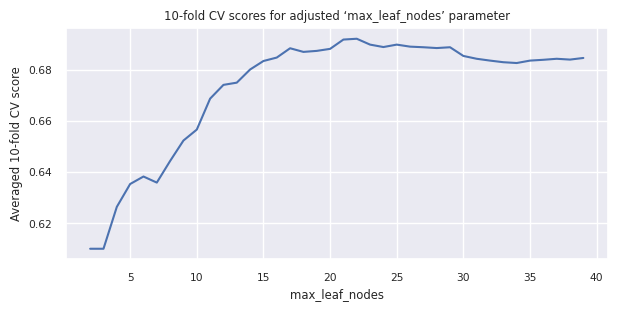

In [32]:
# Adjust max_leaf_nodes parameter
max_leaf_nodes = range(2, 40)
maxleaf_cv = []
for leaf_nodes in max_leaf_nodes:
    # Create decision tree classifier with current max_leaf_nodes value
    dt_leaf = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=leaf_nodes, random_state=21)
    dt_leaf.fit(X_train, y_train)
    predict=dt.predict(X_test)
    # Perform cross-validation and calculate the average score
    cv = cross_val_score(dt_leaf, predictors, target, cv=10)
    maxleaf_cv.append(np.mean(cv))
    print("max_leaf_nodes={},".format(leaf_nodes), "Average 10-Fold CV Score:{},".format(np.mean(cv)))


# Plot 10 CV for adjusted max_leaf_nodes
fig,axes=plt.subplots(1,1,figsize=(7, 3))
#axes.set_xticks(range(0,40,5))
#k=range(2,40,1)
plt.title("10-fold CV scores for adjusted ‘max_leaf_nodes’ parameter")
plt.plot(max_leaf_nodes,maxleaf_cv)
plt.xlabel("max_leaf_nodes")
plt.ylabel("Averaged 10-fold CV score")
plt.grid(True)
plt.show()

### Final Decision Tree with adjusted parameters

Number of tree nodes after optimizing max_leaf_nodes: 43


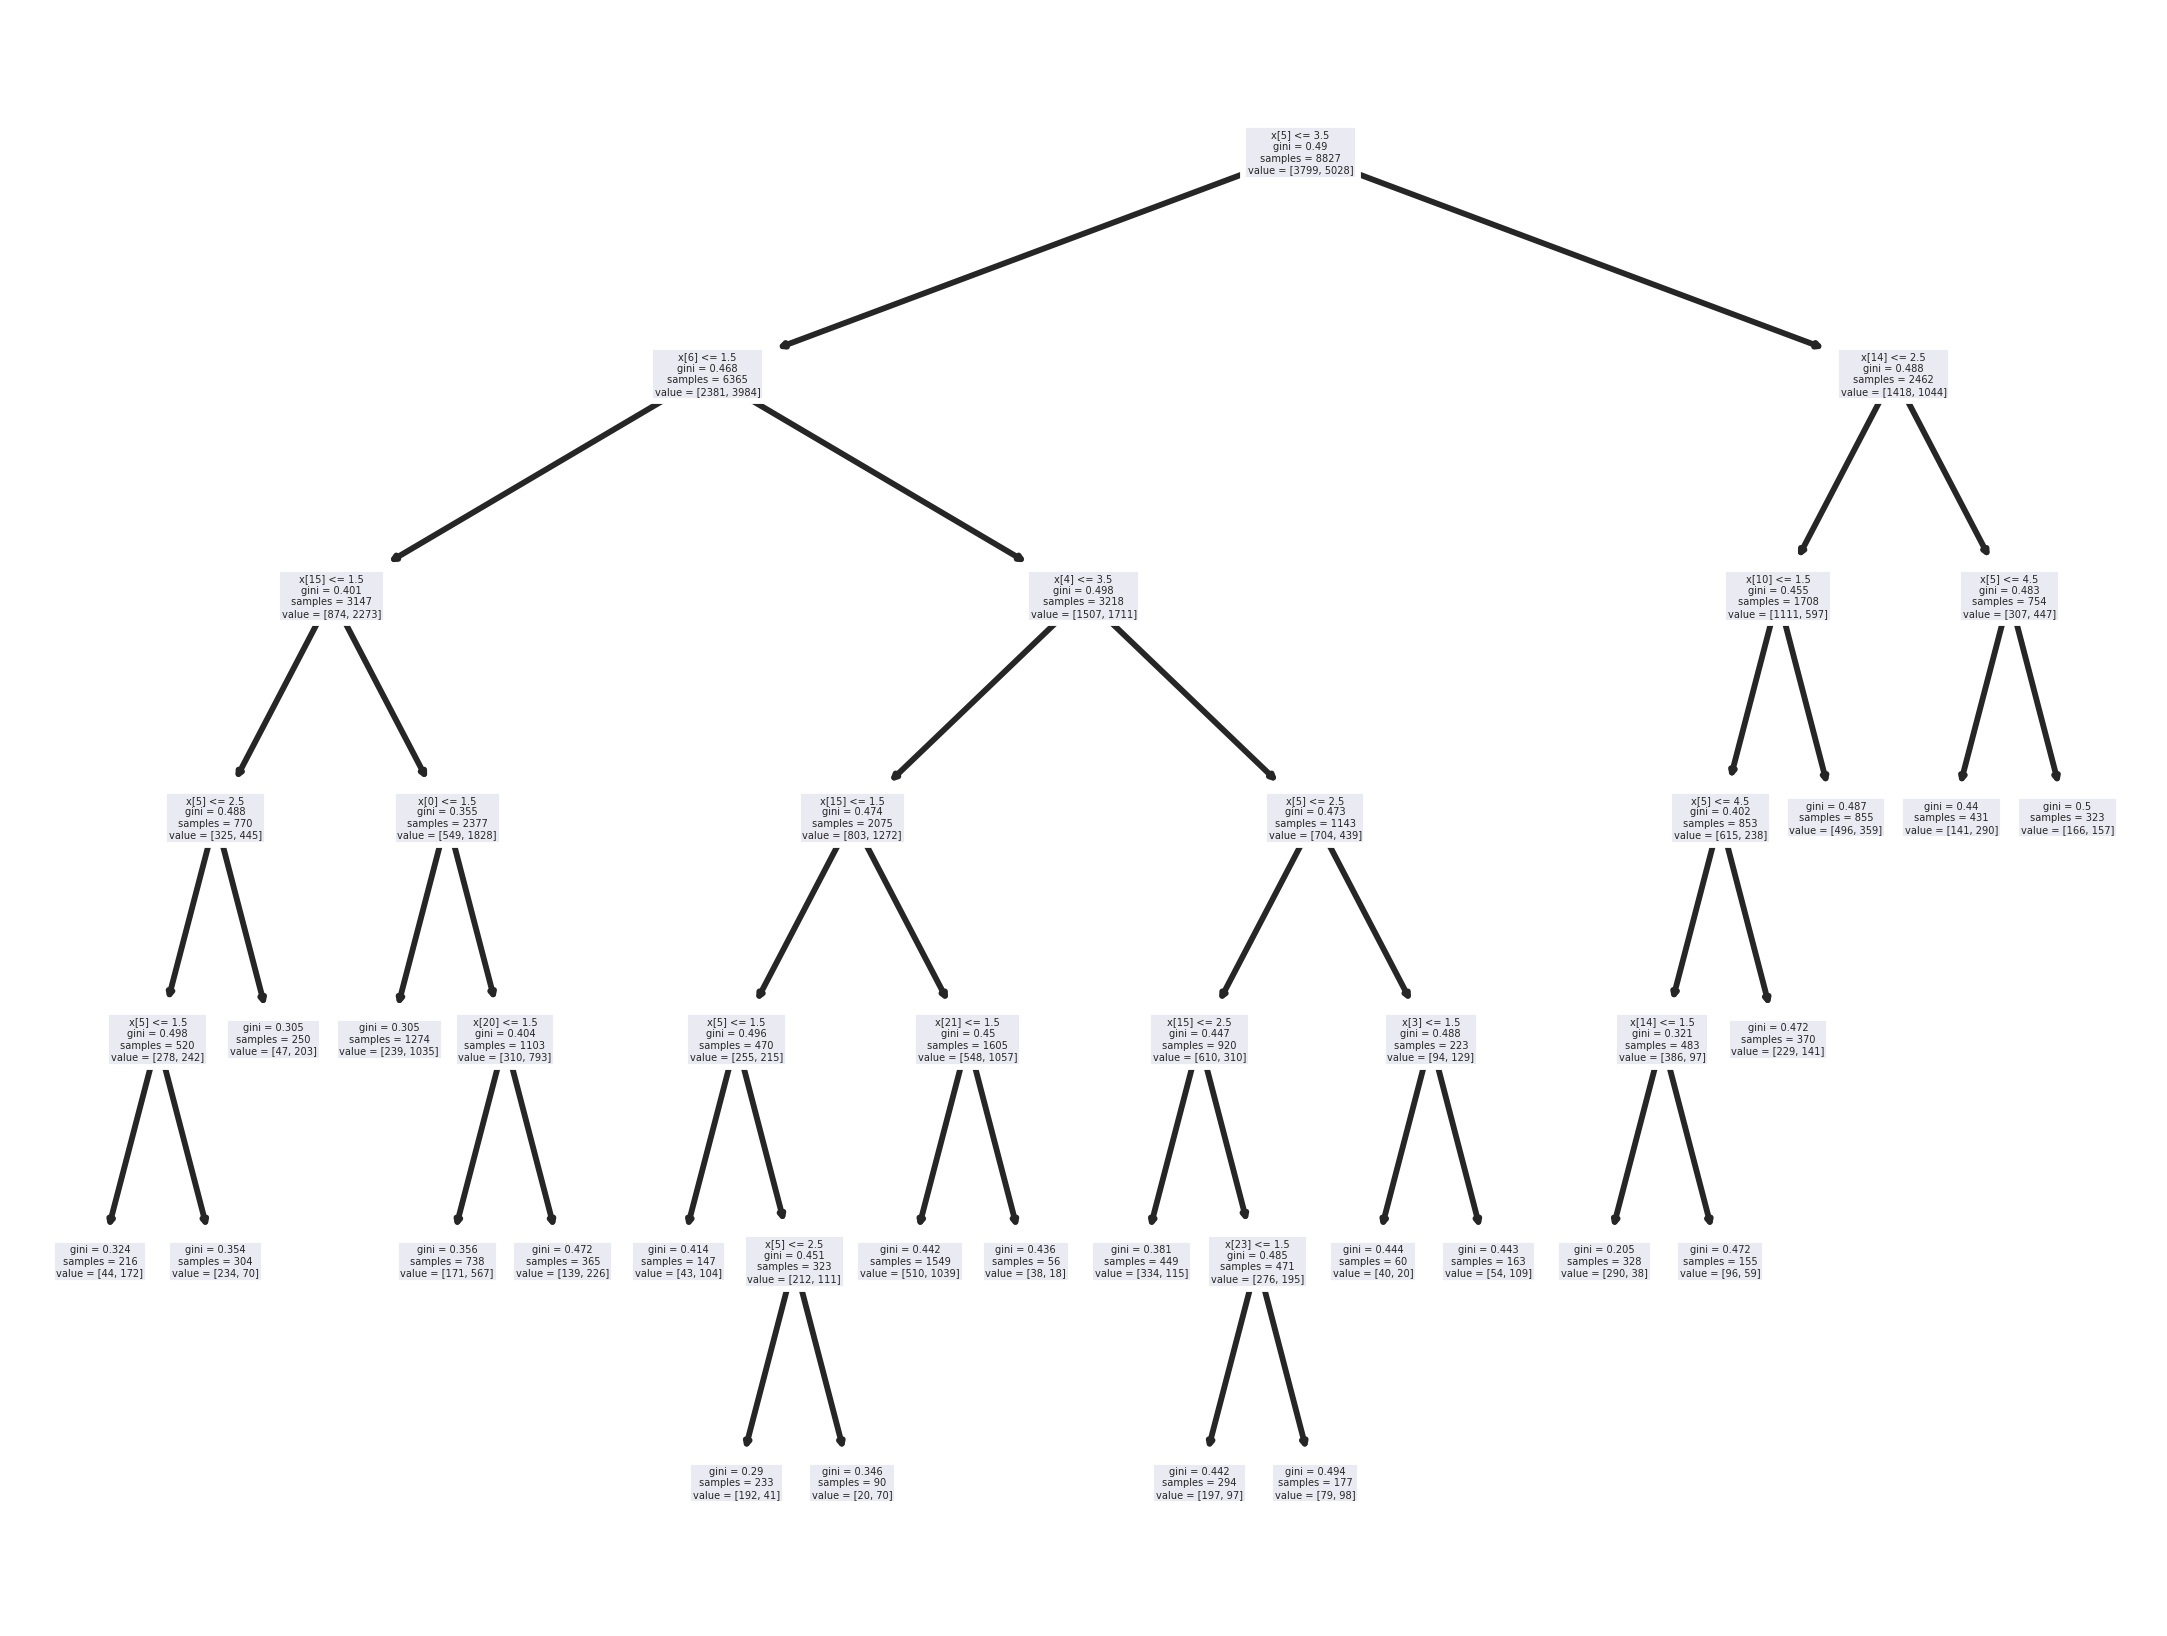

Accuracy score of final model with tuned parameters: 0.70


In [33]:
# Decision tree with the adjusted max_depth and max_leaf_nodes
dt_final = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=22, random_state=21)
dt_final_fit = dt_final.fit(X_train, y_train)
predict_final = dt_final.predict(X_test)

print('Number of tree nodes after optimizing max_leaf_nodes:', dt_final_fit.tree_.node_count)

plt.figure(dpi=420)
tree.plot_tree(dt_final_fit)
plt.show()

acc_score=accuracy_score(y_test, predict_final)
print("Accuracy score of final model with tuned parameters:", '%.2f'%acc_score)

In [34]:
# Decision Tree visualisation using graphvis
'Change path on the second cell, final line if not working'
dot_data = tree.export_graphviz(dt_final, out_file=None,
                              feature_names=X_train.columns,
                              class_names=['0','1'],
                              filled=True, rounded=True,
                              special_characters=True)

mygini_visgraph = graphviz.Source(dot_data)
mygini_visgraph

# Downloads an image of the tree
'''
image_path = "DTC"
mygini_visgraph.render(image_path, format='png')
'''

'\nimage_path = "DTC"\nmygini_visgraph.render(image_path, format=\'png\')\n'

In [35]:
# Actual set' vs 'predicted'
'''
y_pred = dt_final.predict(X_test)

# Create a datframe from 'actual set' and 'predicted'
Actual_Predicted = {'y_Actual':    y_test,
                    'y_Predicted':  y_pred}

df = pd.DataFrame(Actual_Predicted, columns=['y_Actual','y_Predicted'])
df
'''

,y_Actual,y_Predicted
8199,0,1
11463,0,1
1945,0,1
8040,0,1
9433,1,1
...,...,...
2836,1,0
8944,1,1
9478,0,1
10366,0,1


In [36]:
# Actual distribution(test)
'''
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))
'''

{0: 1654, 1: 2129}

In [37]:
# Distribution from prediction(train)
'''
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))
'''

{0: 1438, 1: 2345}

# DTC Evaluations

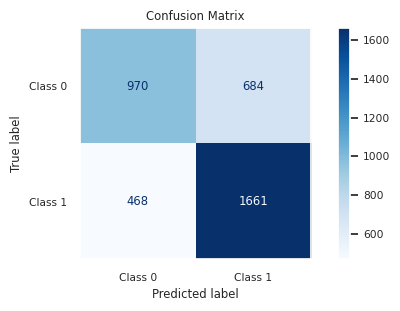

In [38]:
# DTC Evaluation: Confusion Matrix
y_predict = dt_final.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_predict, labels=[0, 1])

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

# Plot confusion matrix without grid lines
fig, ax = plt.subplots(figsize=(7, 3))
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Customize plot appearance
ax.grid(False)  # Turn off grid lines
ax.set_title('Confusion Matrix')

plt.show()

In [39]:
# DTC Evaluation: Model summary report
print(classification_report(y_test, y_predict, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63      1654
           1       0.71      0.78      0.74      2129

    accuracy                           0.70      3783
   macro avg       0.69      0.68      0.68      3783
weighted avg       0.69      0.70      0.69      3783



# Feature Importance 1

### Gini Importance

In [40]:
# Feature Importance (based on the DTC model)
importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(dt_final.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False)
importances

,Feature,Importance
5,coupon,0.477
6,expiration,0.142
15,CoffeeHouse,0.103
4,time,0.095
14,Bar,0.094
10,has_children,0.021
21,toCoupon_GEQ25min,0.016
23,direction_opp,0.014
20,toCoupon_GEQ15min,0.013
0,destination,0.013


# Feature Importance 2

### Chi-squared Method

Feature scores using Chi-square:  

Feature 0: 50.165594
Feature 1: 11.574172
Feature 2: 31.370102
Feature 3: 0.003603
Feature 4: 61.347757
Feature 5: 117.765207
Feature 6: 23.769352
Feature 7: 1.214734
Feature 8: 15.901271
Feature 9: 2.674119
Feature 10: 2.766079
Feature 11: 5.106777
Feature 12: 1.671848
Feature 13: 1.107018
Feature 14: 26.149242
Feature 15: 76.406626
Feature 16: 11.950152
Feature 17: 0.064035
Feature 18: 0.760441
Feature 19: 0.000000
Feature 20: 8.979491
Feature 21: 10.372660
Feature 22: 0.349196
Feature 23: 0.349196


<BarContainer object of 24 artists>

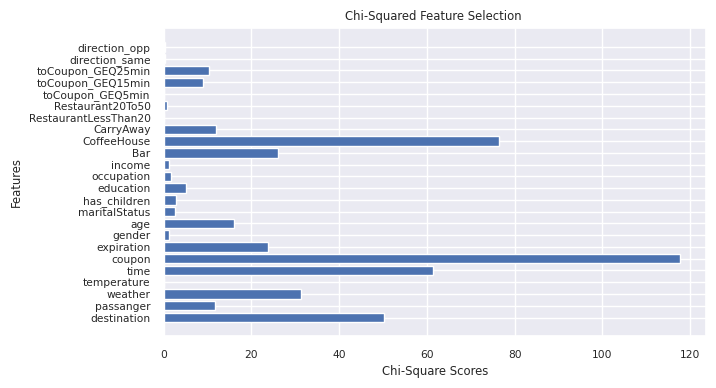

In [41]:
# Chi-squared feature selection
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# Scores for each feature
print('Feature scores using Chi-square: ','\n')
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

# Plot scores
labels = ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp']

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_ylabel("Features")
ax.set_xlabel("Chi-Square Scores")
ax.set_title("Chi-Squared Feature Selection ")
plt.barh([i for i in range(len(fs.scores_))], fs.scores_, tick_label=labels)

# Model 2: MLP

In [42]:
# Scaling - Data Transformation (for MLP)
sc=StandardScaler()
X = sc.fit_transform(predictors)
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

iterations=40, Average 10-fold CV Score:0.6301348136399684
iterations=50, Average 10-fold CV Score:0.6343378271213324
iterations=60, Average 10-fold CV Score:0.6326724821570183
iterations=70, Average 10-fold CV Score:0.6324345757335449
iterations=80, Average 10-fold CV Score:0.6345757335448058
iterations=90, Average 10-fold CV Score:0.6345757335448058
iterations=100, Average 10-fold CV Score:0.6371927042030135
iterations=110, Average 10-fold CV Score:0.6351308485329105
iterations=120, Average 10-fold CV Score:0.637827121332276
iterations=130, Average 10-fold CV Score:0.6369547977795401
iterations=140, Average 10-fold CV Score:0.6366375892149089
iterations=150, Average 10-fold CV Score:0.637430610626487
iterations=160, Average 10-fold CV Score:0.6367168913560667
iterations=170, Average 10-fold CV Score:0.6391752577319588
iterations=180, Average 10-fold CV Score:0.6391752577319588
iterations=190, Average 10-fold CV Score:0.6396510705789057
iterations=200, Average 10-fold CV Score:0.63996

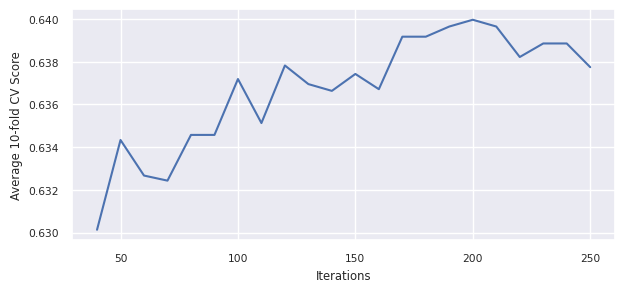

In [43]:
# Testing the model using a 10-fold CV test
iteration_cv=[]
iteration_values = range(40, 251, 10)  # Range of iteration values to test, incrementing by 10

for i in iteration_values:
    mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=i, random_state=21)
    mlp.fit(X_train_scaled, y_train)
    cv = cross_val_score(mlp, X, target, cv=10)

    print("iterations={},".format(i), "Average 10-fold CV Score:{}".format(np.mean(cv)))
    iteration_cv.append(np.mean(cv))

# Plot
plt.figure(figsize=(7, 3))
plt.plot(iteration_values, iteration_cv)
plt.xlabel('Iterations')
plt.ylabel('Average 10-fold CV Score')
plt.grid(True)
plt.show()

## MLP Evaluations

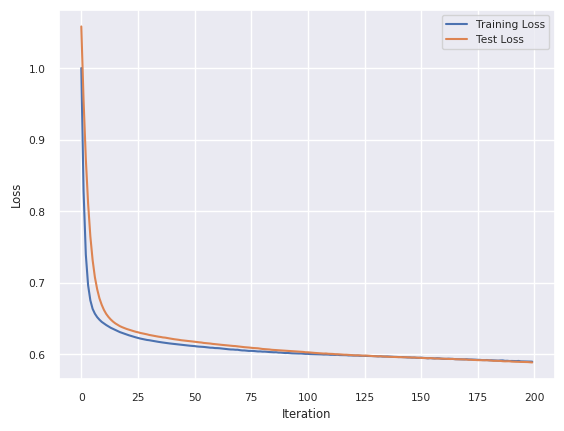

In [47]:
# Evaluation: MLP Loss and error values
k = 10
mlp_test = MLPClassifier(hidden_layer_sizes=(k,), max_iter=200, random_state=21)
mlp_test.fit(X_test_scaled, y_test)

train_loss_values = mlp.loss_curve_
test_loss_values = mlp_test.loss_curve_

plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy Score: 0.6510705789056305


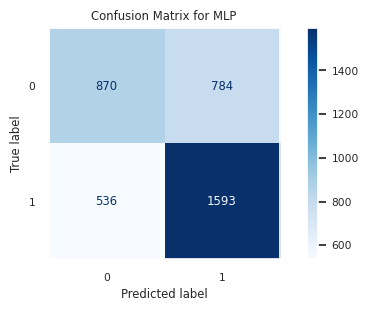

In [44]:
# MLP Evaluation: Confusion Matrix
k = 10
mlp = MLPClassifier(hidden_layer_sizes=(k,), max_iter=200,random_state=21)
mlp.fit(X_train_scaled, y_train)
mlp_predict = mlp.predict(X_test_scaled)

acc = accuracy_score(y_test, mlp_predict)
print("Accuracy Score:", acc)

# Confusion Matrix
y_predict = dt_final.predict(X_test)
cm = confusion_matrix(y_test, mlp_predict, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(7, 3))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.grid(False)
plt.title('Confusion Matrix for MLP')
plt.show()

In [46]:
# MLP Evaluation: Model summary report
print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_test, mlp_predict) * 100))
print('MLP Classification report:\n\n', classification_report(y_test, mlp_predict))

MLP Accuracy: 65.11%
MLP Classification report:

               precision    recall  f1-score   support

           0       0.62      0.53      0.57      1654
           1       0.67      0.75      0.71      2129

    accuracy                           0.65      3783
   macro avg       0.64      0.64      0.64      3783
weighted avg       0.65      0.65      0.65      3783

